In [52]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.data import loadlocal_mnist #to load data from local files


In [53]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 1500)
        self.fc2 = nn.Linear(1500, 500)
        self.fc22 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 10)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc22(x))
        x = self.fc3(x)
        return self.log_softmax(x)
    

In [54]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_f = nn.NLLLoss()
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [55]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_f = nn.NLLLoss(reduction='sum')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_f(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return float(100. *correct / len(test_loader.dataset))

In [57]:
# Training settings
batch_size = 1000
test_batch_size = 1000
epochs = 10
lr = 0.001
momentum = 0.9
seed = 1
log_interval = 800
save_model = False
use_cuda = True # change to False if running without GPU

In [58]:
torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

In [59]:
class TrainClass(torch.utils.data.Dataset):
    def __init__(self, X, device):
        self.data = torch.tensor(X[0], dtype=torch.float32).to(device)
        # self.data.unsqueeze(0)
        self.label = torch.tensor(X[1], dtype=torch.int64).to(device)
        print(type(self.data))
        print(self.label.type)
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data, target = self.data[index], self.label[index]
        return data, target
    
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

X = loadlocal_mnist(
    images_path='train-images-idx3-ubyte',
    labels_path='train-labels-idx1-ubyte'
)
contrast = iaa.Sequential([
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Crop(px=(0, 1))
], random_order=True)
affine = iaa.Sequential([
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.005*255, 0.05*255), per_channel=0.5),
    iaa.Add((-5, 5)),
    iaa.Affine(
        scale={"x": (0.9, 1.05), "y": (0.9, 1.05)},
        shear=(-1, 1)
    )
])
X = list(X)
def perform_augment(seq, data):
    aug = seq(images=data[0])
    data[0] = np.concatenate((data[0], aug), axis=0)
    data[1] = np.concatenate((data[1], data[1]), axis=0)
augments = [contrast, affine]
print(X[0].shape)
X[0] = X[0].reshape(X[0].shape[0], 28, 28)
for x in augments:
    perform_augment(x, X)
print("data after augmentation: {}".format(X[0].shape))

(60000, 784)
data after augmentation: (240000, 28, 28)


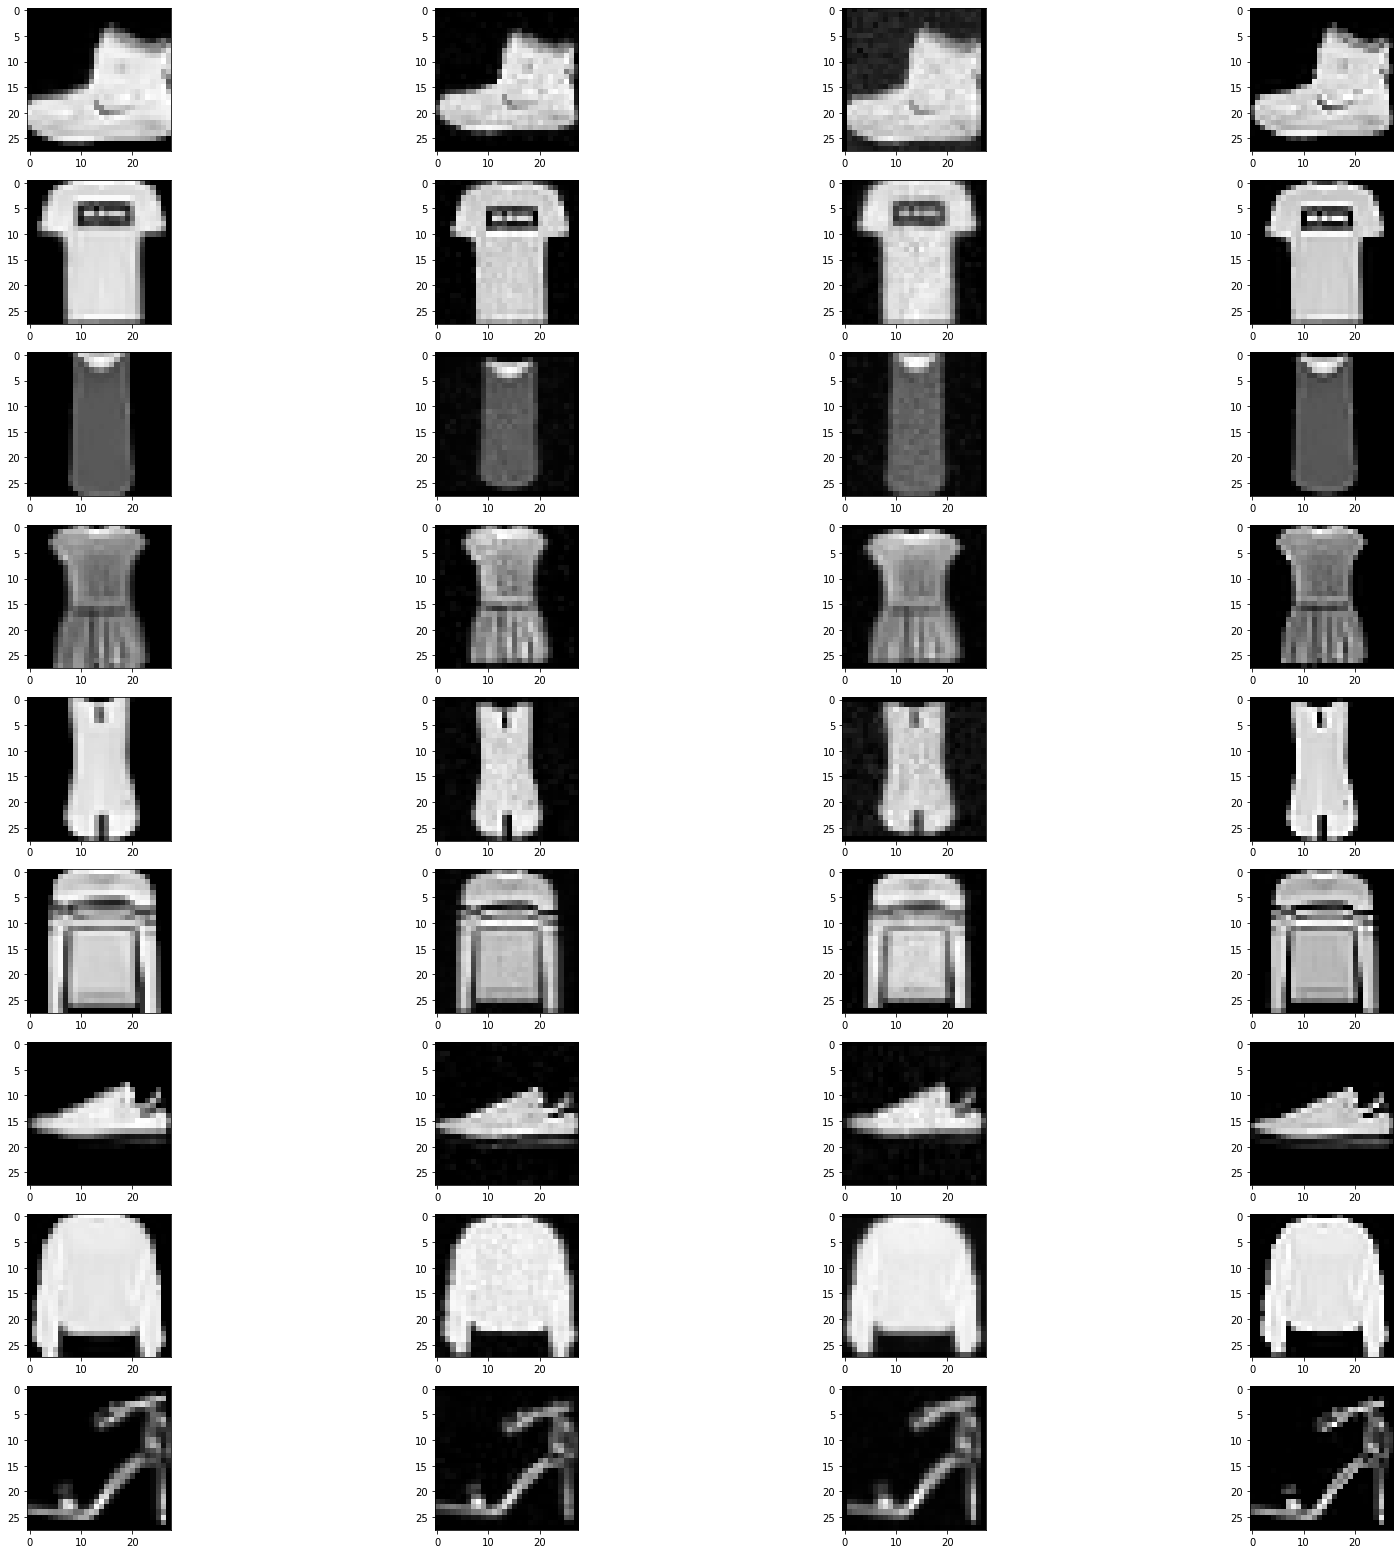

In [60]:
#rotating etc didn't improve performance at all because images in test set are not rotated
# example of how images looks like (4 created from one)
n_rows = 9
offset = 0
images= X[0].reshape(X[0].shape[0], 28, 28)
fig = plt.figure(figsize=(28, 28))
columns = 4
rows = n_rows
for j in range(1, n_rows*columns+1):
    img = images[offset+ int((j-1)/columns)+ int(j%columns)*60000]
    fig.add_subplot(rows, columns, j)
    plt.imshow(img, cmap='gray')
plt.show()

In [61]:
X[0] = X[0].reshape(X[0].shape[0], 784)
t = TrainClass(X, device='cpu')
train_set, val_set = torch.utils.data.random_split(t, [int(X[0].shape[0]/6*5), int(X[0].shape[0]/6)])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size = batch_size, shuffle=True, **kwargs)

<class 'torch.Tensor'>
<built-in method type of Tensor object at 0x000002133F2DA1D8>


In [62]:
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [63]:
test_accuracy = [0 for i in range(epochs+1)]
#not trained model yet
test_accuracy[0] = test(model, device, test_loader)
for epoch in range(1, epochs + 1):
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test_accuracy[epoch] = test(model, device, test_loader)

Train Epoch: 1 [0/200000 (0%)]	Loss: 5.443109
Train Epoch: 2 [0/200000 (0%)]	Loss: 0.433688
Train Epoch: 3 [0/200000 (0%)]	Loss: 0.345493
Train Epoch: 4 [0/200000 (0%)]	Loss: 0.285386
Train Epoch: 5 [0/200000 (0%)]	Loss: 0.318572
Train Epoch: 6 [0/200000 (0%)]	Loss: 0.268227
Train Epoch: 7 [0/200000 (0%)]	Loss: 0.268397
Train Epoch: 8 [0/200000 (0%)]	Loss: 0.202742
Train Epoch: 9 [0/200000 (0%)]	Loss: 0.234914
Train Epoch: 10 [0/200000 (0%)]	Loss: 0.230790


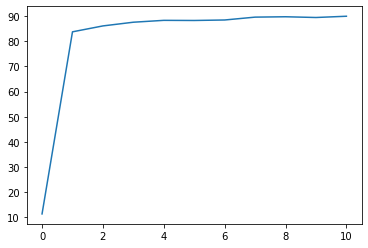

In [64]:
plt.plot(test_accuracy)
plt.show()

Train Epoch: 11 [0/200000 (0%)]	Loss: 0.221941
Train Epoch: 12 [0/200000 (0%)]	Loss: 0.219834
Train Epoch: 13 [0/200000 (0%)]	Loss: 0.220623
Train Epoch: 14 [0/200000 (0%)]	Loss: 0.207399
Train Epoch: 15 [0/200000 (0%)]	Loss: 0.190798
Train Epoch: 16 [0/200000 (0%)]	Loss: 0.180840
Train Epoch: 17 [0/200000 (0%)]	Loss: 0.183513
Train Epoch: 18 [0/200000 (0%)]	Loss: 0.176425
Train Epoch: 19 [0/200000 (0%)]	Loss: 0.188386
Train Epoch: 20 [0/200000 (0%)]	Loss: 0.163082
Train Epoch: 21 [0/200000 (0%)]	Loss: 0.218329
Train Epoch: 22 [0/200000 (0%)]	Loss: 0.141981
Train Epoch: 23 [0/200000 (0%)]	Loss: 0.196714
Train Epoch: 24 [0/200000 (0%)]	Loss: 0.156877
Train Epoch: 25 [0/200000 (0%)]	Loss: 0.128181
Train Epoch: 26 [0/200000 (0%)]	Loss: 0.126221
Train Epoch: 27 [0/200000 (0%)]	Loss: 0.186516
Train Epoch: 28 [0/200000 (0%)]	Loss: 0.146428
Train Epoch: 29 [0/200000 (0%)]	Loss: 0.140098
Train Epoch: 30 [0/200000 (0%)]	Loss: 0.154998


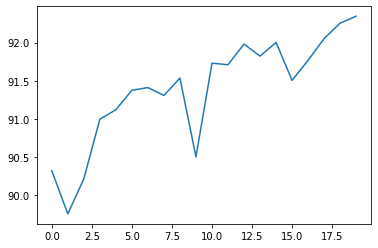

In [65]:
#some more epochs
test_accuracy = [0 for i in range(2*epochs)]
for epoch in range(0, 2*epochs):
    train(log_interval, model, device, train_loader, optimizer, epoch+11)
    test_accuracy[epoch] = test(model, device, test_loader)

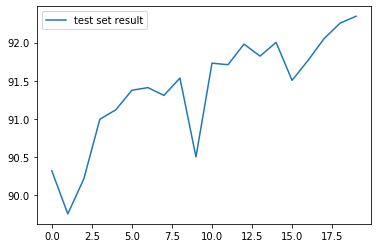

In [73]:
#it is a bit too optimistic, because some of augmented images looks really similiar
# and some of them might've ended up in training set, while others in test set.
plt.plot(test_accuracy, label='test set result')
plt.legend()
plt.show()

In [66]:
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
#train on whole set
train_whole_set_loader = torch.utils.data.DataLoader(
    t,
    batch_size = batch_size, shuffle=True, **kwargs
)
max_epochs = 100
train_accuracy = [0 for i in range(max_epochs)]
for epoch in range(1, max_epochs + 1):
    train(log_interval, model, device, train_whole_set_loader, optimizer, epoch)
    train_accuracy[epoch-1] = test(model, device, test_loader) 

Train Epoch: 1 [0/240000 (0%)]	Loss: 5.439871
Train Epoch: 2 [0/240000 (0%)]	Loss: 0.406597
Train Epoch: 3 [0/240000 (0%)]	Loss: 0.327881
Train Epoch: 4 [0/240000 (0%)]	Loss: 0.315861
Train Epoch: 5 [0/240000 (0%)]	Loss: 0.292652
Train Epoch: 6 [0/240000 (0%)]	Loss: 0.253505
Train Epoch: 7 [0/240000 (0%)]	Loss: 0.240194
Train Epoch: 8 [0/240000 (0%)]	Loss: 0.257415
Train Epoch: 9 [0/240000 (0%)]	Loss: 0.240968
Train Epoch: 10 [0/240000 (0%)]	Loss: 0.229273
Train Epoch: 11 [0/240000 (0%)]	Loss: 0.200161
Train Epoch: 12 [0/240000 (0%)]	Loss: 0.212372
Train Epoch: 13 [0/240000 (0%)]	Loss: 0.171307
Train Epoch: 14 [0/240000 (0%)]	Loss: 0.204088
Train Epoch: 15 [0/240000 (0%)]	Loss: 0.214935
Train Epoch: 16 [0/240000 (0%)]	Loss: 0.169584
Train Epoch: 17 [0/240000 (0%)]	Loss: 0.193845
Train Epoch: 18 [0/240000 (0%)]	Loss: 0.164667
Train Epoch: 19 [0/240000 (0%)]	Loss: 0.147247
Train Epoch: 20 [0/240000 (0%)]	Loss: 0.166615
Train Epoch: 21 [0/240000 (0%)]	Loss: 0.186231
Train Epoch: 22 [0/240

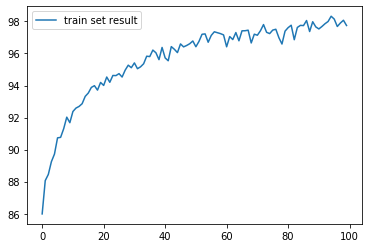

In [74]:
plt.plot(train_accuracy, label='train set result')
plt.legend()
plt.show()

In [72]:
#needed to create file with some random labels to load test data,
# because loadlocal requires you to have labels file for some reason.
t_test = loadlocal_mnist('t10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte')
t_test = list(t_test)
tt = TrainClass(t_test, device=device)

outputs = model(tt.data)
outputs = outputs.argmax(dim=1)
result = pd.DataFrame()
result['Id'] = [i for i in range (0, 10000)]
result['Class'] = outputs.cpu()
result.to_csv("nn_wynik.csv", index=False, header=True)

<class 'torch.Tensor'>
<built-in method type of Tensor object at 0x000002133A5749A8>
